In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

# Importation du jeu de données

In [51]:
emission=pd.read_excel("Jeu_de_donnees.xlsx",sheet_name="donnees")

In [52]:
# forme du jeu de données
emission.shape

(55044, 26)

In [9]:
# aperçu du jeu de données
emission.head()

,lib_mrq,lib_mod_doss,lib_mod,dscom,cnit,tvv,cod_cbr,hybride,puiss_admin_98,puiss_max,...,hc,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,champ_v9,date_maj,Carrosserie,gamme
0,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),M10ALFVP000G340,939AXN1B52C,ES,non,12,147.0,...,0.052,0.032,NaN,0.002,1505,1505,715/2007*692/2008EURO5,2014-03-01 00:00:00,BERLINE,MOY-SUPER
1,ALFA-ROMEO,159,159,159 1750 Tbi (200ch),M10ALFVP000H341,939BXN1B53C,ES,non,12,147.0,...,0.052,0.032,NaN,0.002,1555,1555,715/2007*692/2008EURO5,2014-03-01 00:00:00,BERLINE,MOY-SUPER
2,ALFA-ROMEO,159,159,159 2.0 JTDm (136ch),M10ALFVP000E302,939AXR1B64,GO,non,7,100.0,...,NaN,0.149,0.175,0.001,1565,1565,715/2007*692/2008EURO5,2014-03-01 00:00:00,BERLINE,MOY-SUPER
3,ALFA-ROMEO,159,159,159 2.0 JTDm (136ch),M10ALFVP000F303,939AXR1B64B,GO,non,7,100.0,...,NaN,0.149,0.175,0.001,1565,1565,715/2007*692/2008EURO5,2014-03-01 00:00:00,BERLINE,MOY-SUPER
4,ALFA-ROMEO,159,159,159 2.0 JTDm (170ch),M10ALFVP000G304,939AXS1B66,GO,non,9,125.0,...,NaN,0.164,0.193,0.001,1565,1565,715/2007*692/2008EURO5,2014-03-01 00:00:00,BERLINE,MOY-SUPER


# Data pré-processing et Analyse exploratoire

In [53]:
# Valeurs manqunantes
missing_var=emission.isna().sum().sort_values(ascending=False)
missing_var=pd.DataFrame(missing_var)
missing_var.rename(columns ={0:"Nb de NAN"}, inplace= True)
missing_var["% de NAN"]=round(emission.isna().mean()*100,2).sort_values(ascending=False)
missing_var[missing_var["Nb de NAN"]>0]

,Nb de NAN,% de NAN
date_maj,51797,94.10
hc,45271,82.25
hcnox,9888,17.96
ptcl,2678,4.87
nox,158,0.29
co_typ_1,158,0.29
champ_v9,61,0.11
conso_urb,43,0.08
conso_exurb,43,0.08
conso_mixte,34,0.06


# Commentaire: Suppression des variables contenants des valeurs manquantes

In [54]:
# Suppression des ces valeurs manqunantes
emission=emission.drop(["date_maj","hc"],axis=1)


Les variables date_maj = La data de la dernière mise à jour et hc = emission d'hydrocarbures contiennent plus de 80% de valeurs manquantes. C'est beaucoup trop élévé. Nous supprimerons ces deux variables de notre jeu de données. En effet la variable date_maj ne varie pas d'une année à l'autre car elle ne contient que l'année 2014. Puisque nous analysons des données de 2014, on peut dire que cette variable n'apporte pas une grande information. Quand à la variable hc, elle se rapproche de hcnox (hc+nox)

# Suppression d’autres variables non utiles

In [55]:
emission=emission.drop(["lib_mod_doss","lib_mod","dscom","cnit","tvv","Carrosserie","puiss_admin_98","champ_v9"],axis=1)

Dans avons parcouru et fais des recherches sur l'ensemble des données pour voir celle qui seraient succeptible d'influencer la variable co2 et celles qui n'auraient pas d'influence.

Celles qui n’auraient pas d’influence sont :\
— lib-mod-doss (le modele du dossier)\
— lib-mod (le modèle commercial)\
— dscom (la désignation commerciale)\
— cnit (le Code National d’Identification du Type (CNIT))\
— tvv (le Type-Variante-Version (TVV) ou le type Mines)\
— champ-v9 (le champ V9 du certificat d’immatriculation qui contient la normeEURO)\
— Carrosserie (Carrosserie de la voiture)\
— puiss-admin-98 (la puissance administrative)

# Suppression des individus ayant des valeurs manquantes

In [57]:
emission=emission.dropna()

Après avoir supprimé ces 3 variables, nous avons également supprimé les individus ayant des valeurs manquantes. En effet nous avons de nombreux individus dans notre jeude données et le nombre d’individus comportant des valeurs manquantes n’étaient pas assez nombreux pour influencer la taille du jeu de données. Ainsi, nous sommes passés de 55044 individus et 26 variables à 45151 individus et 24 variables.

In [58]:
emission.shape

(45151, 16)

### Compagnie de fabrication de voiture présents dans ce jeu de données

<img src="compagnie.png" style="text-align:center;width:80%">

In [104]:
import plotly.express as px
fig = px.histogram(emission, x=emission['lib_mrq'])
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(
    
    xaxis_title="Compagnie de fabrication"
)
fig.update_layout(template='plotly_white')

## Compagnie de fabrication vs emission de co2

<img src="Compagnie_vs_co2.png" style="text-align:center;width:80%">

In [105]:
import plotly.graph_objects as go # l'importation de ce module est nécessaire
import plotly.offline as py



df1=emission.groupby('lib_mrq')['co2'].mean().sort_values(ascending=False)[:16].to_frame()


trace = go.Bar(
    x=df1.index,
    y=df1.co2,
    marker=dict(
        color=df1.co2,
        colorscale = 'Reds')
)

data = [trace]
layout = go.Layout(
    title='Compagnie de fabrication', 
    yaxis = dict(title = 'g de Co2 en moyenne')
)

fig = go.Figure(data=data)

fig.update_layout(template='plotly_white',
                  xaxis_title="Compagnie de fabrication & emission de co2")


# Pairplot - Co2 et les variables quantitatives

In [30]:
# Ici, nous divisons notre dataset en deux. l'un contenant les données de types caratère et l'autre
# contenant les données de type numérique.
catactere_data=[]
numerique_data=[]
for i,c in enumerate(emission.dtypes):
    if c==object:
        catactere_data.append(emission.iloc[:,i])
    else:
        numerique_data.append(emission.iloc[:,i])
catactere_data=pd.DataFrame(catactere_data).transpose()
numerique_data=pd.DataFrame(numerique_data).transpose()

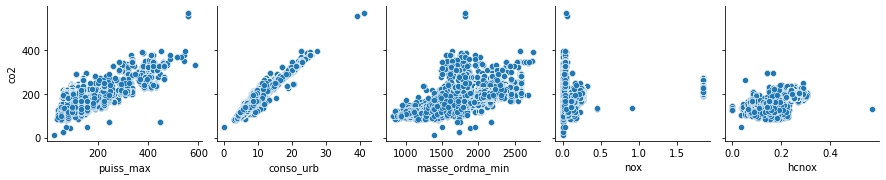

In [31]:
import seaborn as sns
pp = sns.pairplot(data=numerique_data,
                  y_vars=['co2'],
                  x_vars=['puiss_max', 'conso_urb','masse_ordma_min','nox', 'hcnox'])

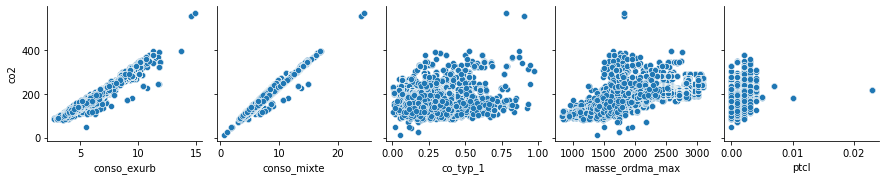

In [32]:
pp = sns.pairplot(data=numerique_data,
                  y_vars=['co2'],
                  x_vars=['conso_exurb', 'conso_mixte', 'co_typ_1','masse_ordma_max','ptcl'])

# Boxplot pour detecter les outliers

<img src="Boxplot_out.png" style="text-align:center;width:80%">

In [106]:
import plotly.express as px
fig = px.box(emission, y="co2")
fig.update_layout(template='plotly_white')

## Histogramme de la variable cible pour detecter les outliers

<img src="hist_out.png" style="text-align:center;width:80%">

In [107]:
import plotly.express as px

fig = px.histogram(emission, x="co2",nbins=20)
fig.update_layout(template='plotly_white')
fig.update_layout(template='plotly_white')

# Commentaire

Nous constatons qu'il y'a des outliers dans ce jeu de données. Nous allons donc proceder à leur traitement

# Gestion des valeurs aberrantes

In [59]:
# Formule
Q1=emission['co2'].quantile(0.25)
Q3=emission['co2'].quantile(0.75)
EIQ= Q3-Q1
BI=Q1-1.5*EIQ
BS=Q3+1.5*EIQ

In [60]:
# Detection des données sans outliers.

df_filtered = emission[(emission["co2"] <= BS) & (emission["co2"] >= BI)]
df_filtered.head(2)

,lib_mrq,cod_cbr,hybride,puiss_max,typ_boite_nb_rapp,conso_urb,conso_exurb,conso_mixte,co2,co_typ_1,nox,hcnox,ptcl,masse_ordma_min,masse_ordma_max,gamme
345,AUDI,GO,non,180.0,A 7,7.2,5.5,6.2,161.0,0.389,0.145,0.176,0.0,1825,1825,MOY-SUPER
468,AUDI,GO,non,230.0,A 8,7.9,6.0,6.7,176.0,0.288,0.154,0.181,0.0,1985,1985,LUXE


In [61]:
df_filtered.shape

(41303, 16)

# Partie ACP

In [ ]:
# Fais avec le logiciel R

# Partie modélisation

In [64]:
# Encodage des variables qualitatives

In [62]:
df_filtered=pd.get_dummies(df_filtered,drop_first = True, dtype=np.int64,prefix_sep = '_')

In [63]:
df_filtered.shape

(41303, 55)

In [65]:
# Selection de variables
X = df_filtered.drop('co2', axis=1)
Y = df_filtered['co2']

In [66]:
# Verifier la taille X
X.shape

(41303, 54)

In [67]:
# Verifier la taille Y
Y=pd.DataFrame({"Y":Y})
Y.shape

(41303, 1)

In [68]:
# Training set et Testing Set
from sklearn.model_selection import train_test_split # training set et testing test

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

# Modèle 1: Arbre de regression

In [72]:
#Import the regression tree model
from sklearn.tree import DecisionTreeRegressor

regression_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=5)
regression_model.fit(x_train,y_train)
predicted = regression_model.predict(x_test)



print("accuracy: "+ str(regression_model.score(x_test,y_test)*100))
print("Mean absolute error: {}".format(mean_absolute_error(y_test,predicted)))
print("Mean squared error: {}".format(mean_squared_error(y_test,predicted)))
R2 = r2_score(y_test,predicted)
print('R Squared: {}'.format(R2))
n=x_test.shape[0]
p=x_test.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 99.98630599217677
Mean absolute error: 0.020546346063642976
Mean squared error: 0.025505349332084946
R Squared: 0.9998630599217677
Adjusted R Squared: 0.9998624716244389


# Modèle 2: XGBoost

In [73]:
 # Step 1 - Import the library
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(x_train,y_train)
predicted_y = model.predict(x_test)


print("accuracy: "+ str(model.score(x_test,y_test)*100))
print("Mean absolute error: {}".format(mean_absolute_error(y_test,predicted_y)))
print("Mean squared error: {}".format(mean_squared_error(y_test,predicted_y)))
R2 = r2_score(y_test,predicted_y)
print('R Squared: {}'.format(R2))
n=x_test.shape[0]
p=x_test.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

C:\Users\kouas\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\kouas\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[15:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 98.93471067710435
Mean absolute error: 0.018400451940924864
Mean squared error: 0.10717456218222904
R Squared: 0.9994245719696422
Adjusted R Squared: 0.9994220999192565


# Modèle 3: Regression linéaire multiple

In [74]:
#from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels


reg_multi = sm.OLS(Y, X).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.117e+05
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:41:32   Log-Likelihood:                -29140.
No. Observations:               41303   AIC:                         5.839e+04
Df Residuals:                   41250   BIC:                         5.884e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
puiss_max                 0.00

# Verification des hypothèse du modele de regression linéaire multiple

### - 1- La multicolinéarité

Nous constatons que le score des 3 modèles construit est beaucoup trop élévé. Il doit avoir des problèmes dans notre jeu de données.

Le modèle de regression linéaire ci-dessus indique qu'il s'agit d'un problème de multicollinearité.

##### Matrice de corrélation

In [83]:
# Dectection des variables quantitatives.
d_f=df_filtered[['puiss_max', 'conso_urb', 'conso_exurb', 'conso_mixte', 'co2','co_typ_1', 'nox', 'hcnox', 'ptcl','masse_ordma_min','masse_ordma_max']]

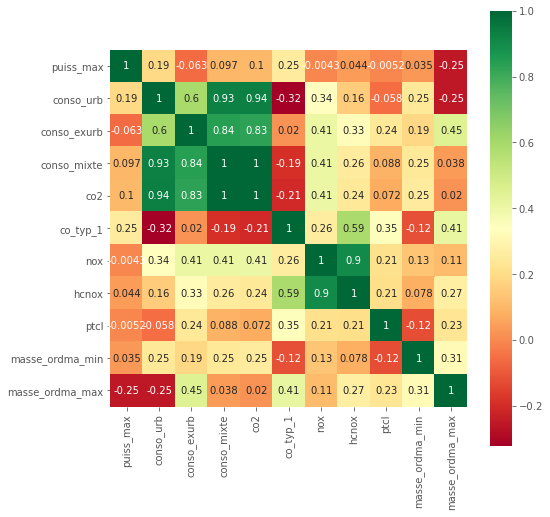

In [85]:
# Construction de la matrice de correlation

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
p=sns.heatmap(d_f.corr(), annot=True,cmap='RdYlGn',square=True) 

D'après la matrice ci-dessus, il existe une corrélation forte entre:
- Consommation mixte et co2=1
- Consommation urbaine= 0.94
- Consommation extraurbaine= 0.83

Ces variables sont très corrélées

#### Vérifier la colinéarité des variables

In [86]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

C:\Users\kouas\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



[147.45376179711678,
 59.49056382485206,
 296.47225153314236,
 14.906800011996895,
 45.13508533986609,
 66.78324360610675,
 1.946217538598623,
 3.5422893667340163,
 10.343555852024686,
 2.0231446072076276,
 2.075073856707613,
 3.1922068565522737,
 15.574649758775434,
 14.827596871868353,
 1.6680993894478615,
 1.410918160628014,
 1.2933190240955275,
 1.238656627763493,
 5.4478776631220285,
 1.4030912106779634,
 1.492103828469191,
 3.751926660970601,
 1.2993261735215904,
 868.084650979808,
 2.2871260294398423,
 22.80786861287575,
 3.581120789860704,
 3.0074985914559007,
 1.777420375563948,
 3.0980177497360972,
 1.1063651857295493,
 1.2969486936764858,
 1.4326531215153977,
 inf,
 1.2090095841202149,
 3.3136264755434177,
 849.9418916543578,
 1.8648633698158814,
 6790.004506547103,
 1.8167854838208328,
 1.7012519556148917,
 3.3275616820818903,
 4.609025095692467,
 1.0651963379009726,
 1.451145281218097,
 7.846537911812919,
 1.103594490375702,
 inf,
 22.72562692441464,
 496.72723985013255,
 

### Commentaire

Ici, on voit qu'il y'a des coefficients superieurs à 10. Il y'a bien un problème de colinéarité.

# --- Chercher à vérifier les autres hypothèse du modèle.---

**Nous souhaitons continuer avec le modèle de régression linéaire mulptiple car nous savons qu'il exite une regression backward qui permet de detecter automatiquement les variables utiles.**

# Regression Backward pour detecter automatiquement les variables utiles.

In [96]:
# Manipulation exprès pour faire quelques changement
df_filtered.to_excel(r"C:\Users\kouas\Documents\Université de Montpellier\Projet M1_Semestre_1\Openclass\df_filtered.xlsx", index = True)


In [97]:
df_filtered=pd.read_excel("df_filtered.xlsx")

In [98]:
df_filtered.columns

Index(['Unnamed: 0', 'puiss_max', 'conso_urb', 'conso_exurb', 'conso_mixte',
       'co2', 'co_typ_1', 'nox', 'hcnox', 'ptcl', 'masse_ordma_min',
       'masse_ordma_max', 'lib_mrq_BMW', 'lib_mrq_CHEVROLET',
       'lib_mrq_CITROEN', 'lib_mrq_FIAT', 'lib_mrq_FORD', 'lib_mrq_HONDA',
       'lib_mrq_HYUNDAI', 'lib_mrq_INFINITI', 'lib_mrq_JAGUAR', 'lib_mrq_JEEP',
       'lib_mrq_KIA', 'lib_mrq_LANCIA', 'lib_mrq_LAND_ROVER',
       'lib_mrq_MASERATI', 'lib_mrq_MERCEDES', 'lib_mrq_MITSUBISHI',
       'lib_mrq_NISSAN', 'lib_mrq_OPEL', 'lib_mrq_PEUGEOT', 'lib_mrq_PORSCHE',
       'lib_mrq_RENAULT', 'lib_mrq_SEAT', 'lib_mrq_SKODA', 'lib_mrq_SSANGYONG',
       'lib_mrq_SUBARU', 'lib_mrq_SUZUKI', 'lib_mrq_TOYOTA',
       'lib_mrq_VOLKSWAGEN', 'lib_mrq_VOLVO', 'cod_cbr_GO', 'hybride_oui',
       'typ_boite_nb_rapp_A_6', 'typ_boite_nb_rapp_A_7',
       'typ_boite_nb_rapp_A_8', 'typ_boite_nb_rapp_D_5',
       'typ_boite_nb_rapp_M_5', 'typ_boite_nb_rapp_M_6',
       'typ_boite_nb_rapp_S_6', 'typ_boi

In [99]:
df_filtered=df_filtered.drop(["Unnamed: 0"],axis=1)

In [100]:
df_filtered.shape

(41303, 55)

In [101]:
df_filtered.columns

Index(['puiss_max', 'conso_urb', 'conso_exurb', 'conso_mixte', 'co2',
       'co_typ_1', 'nox', 'hcnox', 'ptcl', 'masse_ordma_min',
       'masse_ordma_max', 'lib_mrq_BMW', 'lib_mrq_CHEVROLET',
       'lib_mrq_CITROEN', 'lib_mrq_FIAT', 'lib_mrq_FORD', 'lib_mrq_HONDA',
       'lib_mrq_HYUNDAI', 'lib_mrq_INFINITI', 'lib_mrq_JAGUAR', 'lib_mrq_JEEP',
       'lib_mrq_KIA', 'lib_mrq_LANCIA', 'lib_mrq_LAND_ROVER',
       'lib_mrq_MASERATI', 'lib_mrq_MERCEDES', 'lib_mrq_MITSUBISHI',
       'lib_mrq_NISSAN', 'lib_mrq_OPEL', 'lib_mrq_PEUGEOT', 'lib_mrq_PORSCHE',
       'lib_mrq_RENAULT', 'lib_mrq_SEAT', 'lib_mrq_SKODA', 'lib_mrq_SSANGYONG',
       'lib_mrq_SUBARU', 'lib_mrq_SUZUKI', 'lib_mrq_TOYOTA',
       'lib_mrq_VOLKSWAGEN', 'lib_mrq_VOLVO', 'cod_cbr_GO', 'hybride_oui',
       'typ_boite_nb_rapp_A_6', 'typ_boite_nb_rapp_A_7',
       'typ_boite_nb_rapp_A_8', 'typ_boite_nb_rapp_D_5',
       'typ_boite_nb_rapp_M_5', 'typ_boite_nb_rapp_M_6',
       'typ_boite_nb_rapp_S_6', 'typ_boite_nb_rapp_V_0

In [102]:
columns = ['puiss_max', 'conso_urb', 'conso_exurb', 'conso_mixte', 'co2',
       'co_typ_1', 'nox', 'hcnox', 'ptcl', 'masse_ordma_min',
       'masse_ordma_max', 'lib_mrq_BMW', 'lib_mrq_CHEVROLET',
       'lib_mrq_CITROEN', 'lib_mrq_FIAT', 'lib_mrq_FORD', 'lib_mrq_HONDA',
       'lib_mrq_HYUNDAI', 'lib_mrq_INFINITI', 'lib_mrq_JAGUAR', 'lib_mrq_JEEP',
       'lib_mrq_KIA', 'lib_mrq_LANCIA', 'lib_mrq_LAND_ROVER',
       'lib_mrq_MASERATI', 'lib_mrq_MERCEDES', 'lib_mrq_MITSUBISHI',
       'lib_mrq_NISSAN', 'lib_mrq_OPEL', 'lib_mrq_PEUGEOT', 'lib_mrq_PORSCHE',
       'lib_mrq_RENAULT', 'lib_mrq_SEAT', 'lib_mrq_SKODA', 'lib_mrq_SSANGYONG',
       'lib_mrq_SUBARU', 'lib_mrq_SUZUKI', 'lib_mrq_TOYOTA',
       'lib_mrq_VOLKSWAGEN', 'lib_mrq_VOLVO', 'cod_cbr_GO', 'hybride_oui',
       'typ_boite_nb_rapp_A_6', 'typ_boite_nb_rapp_A_7',
       'typ_boite_nb_rapp_A_8', 'typ_boite_nb_rapp_D_5',
       'typ_boite_nb_rapp_M_5', 'typ_boite_nb_rapp_M_6',
       'typ_boite_nb_rapp_S_6', 'typ_boite_nb_rapp_V_0', 'gamme_LUXE',
       'gamme_MOY_INFER', 'gamme_MOY_INFERIEURE', 'gamme_MOY_SUPER',
       'gamme_SUPERIEURE']

reg_backward = backward_selected(df_filtered[columns], 'co2')

_______________________________
co2 ~ cod_cbr_GO + typ_boite_nb_rapp_D_5 + conso_exurb + lib_mrq_TOYOTA + lib_mrq_INFINITI + gamme_MOY_SUPER + lib_mrq_FIAT + typ_boite_nb_rapp_A_7 + lib_mrq_MITSUBISHI + lib_mrq_SKODA + typ_boite_nb_rapp_S_6 + gamme_MOY_INFER + typ_boite_nb_rapp_V_0 + gamme_SUPERIEURE + lib_mrq_CITROEN + hybride_oui + nox + lib_mrq_VOLKSWAGEN + hcnox + lib_mrq_NISSAN + lib_mrq_SEAT + lib_mrq_BMW + typ_boite_nb_rapp_M_5 + puiss_max + masse_ordma_max + ptcl + conso_mixte + lib_mrq_HONDA + lib_mrq_LANCIA + lib_mrq_PEUGEOT + lib_mrq_OPEL + co_typ_1 + lib_mrq_SUZUKI + lib_mrq_FORD + lib_mrq_LAND_ROVER + lib_mrq_JAGUAR + lib_mrq_MASERATI + typ_boite_nb_rapp_A_8 + lib_mrq_RENAULT + lib_mrq_KIA + lib_mrq_SSANGYONG + lib_mrq_HYUNDAI + typ_boite_nb_rapp_M_6 + lib_mrq_SUBARU + lib_mrq_JEEP + typ_boite_nb_rapp_A_6 + lib_mrq_CHEVROLET + gamme_MOY_INFERIEURE + lib_mrq_MERCEDES + gamme_LUXE + conso_urb + lib_mrq_PORSCHE + masse_ordma_min + lib_mrq_VOLVO + 1
remove lib_mrq_HYUNDAI (p-v

remove lib_mrq_PEUGEOT (p-value : 0.141 )

_______________________________
co2 ~ cod_cbr_GO + typ_boite_nb_rapp_D_5 + conso_exurb + lib_mrq_TOYOTA + lib_mrq_INFINITI + gamme_MOY_SUPER + lib_mrq_FIAT + typ_boite_nb_rapp_A_7 + lib_mrq_MITSUBISHI + lib_mrq_SKODA + typ_boite_nb_rapp_S_6 + gamme_MOY_INFER + gamme_SUPERIEURE + lib_mrq_CITROEN + hybride_oui + nox + lib_mrq_VOLKSWAGEN + hcnox + lib_mrq_NISSAN + lib_mrq_SEAT + lib_mrq_BMW + typ_boite_nb_rapp_M_5 + puiss_max + masse_ordma_max + ptcl + conso_mixte + lib_mrq_LANCIA + lib_mrq_OPEL + co_typ_1 + lib_mrq_FORD + lib_mrq_LAND_ROVER + lib_mrq_JAGUAR + typ_boite_nb_rapp_A_8 + lib_mrq_RENAULT + lib_mrq_KIA + lib_mrq_SSANGYONG + lib_mrq_JEEP + typ_boite_nb_rapp_A_6 + lib_mrq_CHEVROLET + lib_mrq_MERCEDES + gamme_LUXE + conso_urb + lib_mrq_PORSCHE + masse_ordma_min + lib_mrq_VOLVO + 1
remove lib_mrq_CITROEN (p-value : 0.227 )

_______________________________
co2 ~ cod_cbr_GO + typ_boite_nb_rapp_D_5 + conso_exurb + lib_mrq_TOYOTA + lib_mrq_INF

# Même après le backward, le modèle indique toujours qu'il y'a un fort problème de multicollinearité


Notes:\
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.\
[2] The smallest eigenvalue is 5.14e-22. This might indicate that there are strong multicollinearity problems or that the design matrix is singular.

Questions

- Comment résoudre le problème de multicolinéarité afin d'améliorer le modèle ? (peut-être que je sois supprimer les variables qui sont trop correlées avec la variable cible, mais lesquelles supprimer et lesquelles laisser ?)
- Quand est-il des variables qualitatives ?